In [170]:
import zarr
from buffer.frame_buffer import ReplayBuffer
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

def rotate_origin_only(x, y, radians):
    """Only rotate a point around the origin (0, 0)."""
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [171]:
replay_buffer = ReplayBuffer(int(2e3), history_size=1, dshape=(160, 384, 3), dtype=torch.uint8, goal_size=3)
replay_buffer.load(Path('/Users/nimit/Documents/robomaster/habitat/160x384'))
# zarr.load('/Users/nimit/Documents/robomaster/habitat/160x384', mode='r')

[!] loaded buffer


/Users/nimit/anaconda3/envs/robot/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


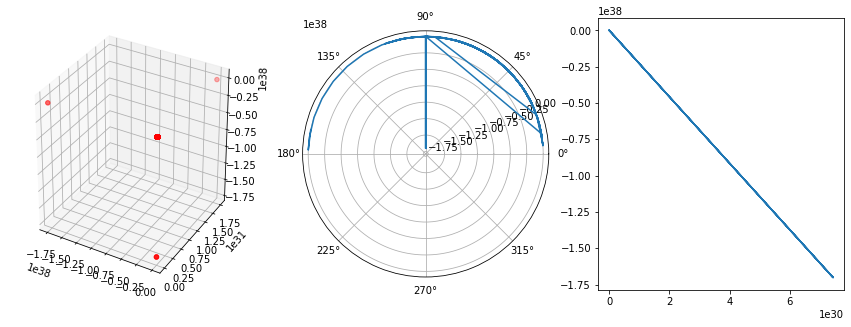

In [174]:
# 0 -> 140
# 140 -> 269
# 269 -> 431
r, c, s = replay_buffer.goals.T

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(c, s, r, c='r', marker='o')

ax2 = fig.add_subplot(132, projection='polar')
t = np.arccos(c)
ax2.plot(t, r)

ax3 = fig.add_subplot(133)
ax3.plot(r*np.cos(t), r*np.sin(t))

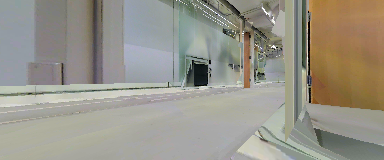

In [420]:
i = 95
Image.fromarray(replay_buffer.targets[i].squeeze().numpy())

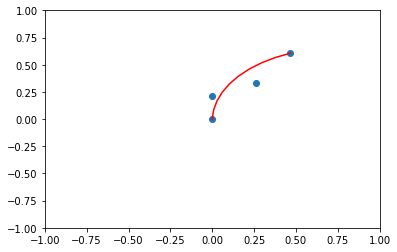

In [421]:
movement = replay_buffer.actions[i:i+9] == 1
k = np.searchsorted(np.cumsum(movement), 5).item()

# stupid
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_ylim(-1,1)
ax.set_xlim(-1,1)

R = r[i:i+k][movement[:k]]-r[i] # relative
R = -0.35 * np.abs(R / R.mean())
T = t[i:i+k][movement[:k]]-t[i+1] # absolute

x, y = rotate_origin_only(R*np.cos(T), R*np.sin(T), np.pi/2)
if T.shape[0] > 1 and (y < 0).sum() == 0: # if behind camera, then use prev
    _t = np.linspace(T[0], T[-1], 10)
    _r = np.linspace(R[0], R[-1], 10)
    _x, _y = rotate_origin_only(_r*np.cos(_t), _r*np.sin(_t), np.pi/2)
    init = True

if init:
    ax.scatter(x, y)
    ax.plot(_x, _y, c='r')

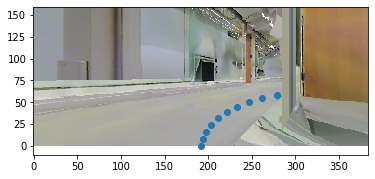

In [432]:
f = 384 / (2 * np.tan(120 * np.pi / 360))
A = torch.tensor([[1.675*f,   0.0000, 192.0000],
                  [  0.0000, 0.875*f,  0.0000],
                  [  0.0000,   0.0000,   1.0000]])

M = torch.FloatTensor(np.stack([_x, _y, np.ones(_y.shape[0])]))
u, v = torch.mm(A, M)[:2]

plt.imshow(replay_buffer.targets[i].squeeze().numpy()[::-1], origin='lower')
plt.scatter(u, v)

In [424]:
u, v

(tensor([192.0000, 193.5601, 197.3016, 203.1857, 211.1528, 221.1229, 232.9959,
         246.6525, 261.9552, 278.7492]),
 tensor([ 0.0000,  8.2055, 16.2575, 24.0376, 31.4294, 38.3199, 44.6001, 50.1661,
         54.9199, 58.7703]))

In [ ]:
import sys
sys.path.append('/Users/nimit/Documents/robomaster')
from dji_project.carla_experiments.highway_dataset import ConverterTorch

converter = ConverterTorch(h=160, w=384, fov=120,
                           hack=5, cam_height=.25, pixels_per_world=5)